<a href="https://colab.research.google.com/github/akshaykadidal/BasicFunctions/blob/master/Keras_nn_limitvalues.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have always had problems predicting continious values. When we predict a value that cannot be negative the model would predict negative value. Now with the nn architecture we have a solution to the problem

1. standardize your y_train with min max standardization (set your own min max if you like)
2. build you nn. In the output layer select sigmoid activation with mape or rmse as loss function. 
3. Convert your prediction to actual scale. This will ensure that the values that you are predicting will always fall between the min and max values determined by you

Let's try this with Titanic data set to predict age of the passengers

The Titanic data is sourced from Kaggle.com 


In [1]:
!pip install distance

     |████████████████████████████████| 184kB 3.3MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=d4b7298f8f39eb2b5b350e6a29639bedde44af4ee7e1499101b234dbdee54e68
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [2]:
!pip install StringDist

  Created wheel for StringDist: filename=StringDist-1.0.9-cp36-cp36m-linux_x86_64.whl size=24378 sha256=7b6026136624d1834ef335ea92909de78c3a90efe6da46f4f96f01ba825d64a7
  Stored in directory: /root/.cache/pip/wheels/c3/1b/bb/bf0de4d64d8ca38759811fe3353e441f12feb606fb3d1d2e11
Successfully built StringDist


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import io
from google.colab import files
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.cluster
import distance
import stringdist

In [0]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics 
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

In [7]:
upload = files.upload()

Saving train.csv to train.csv


In [0]:
df1 = pd.read_csv(io.BytesIO(upload['train.csv']))

In [9]:
upload = files.upload()

Saving test.csv to test.csv


In [0]:
df2 =  pd.read_csv(io.BytesIO(upload['test.csv']))

In [0]:
data = pd.concat([df1,df2], axis = 0)

In [12]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,chk,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN,NaN,NaN,NaN
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,NaN,NaN,NaN,NaN,NaN
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN,NaN,NaN,NaN
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,NaN,NaN,NaN,NaN,NaN
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN,NaN,NaN,NaN


In [13]:
print (data.shape, 'data')
print (df1.shape, 'df1')
print (df2.shape, ' df2')

(1309, 17) data
(891, 12) df1
(418, 16)  df2


In [14]:
data.Age.describe()

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64

In [0]:
%matplotlib inline

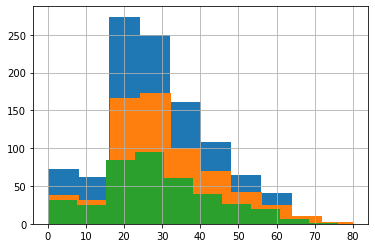

In [16]:
hist = data.Age.hist()
hist.plot()
hist_m = data[data['Sex']=='male'].Age.hist()
hist_f = data[data['Sex']=='female'].Age.hist()
plt.show()

Creating some feature engineered columns
Looks like people who bought tickets together have one ticket number / id. Their Fare is also based on number of tickets sold (or so it appears)

In [0]:
data['GroupSize'] = data.groupby('Ticket')['Ticket'].transform('count')

In [0]:
data['Istoddler'] = (data['Age']<4)*1
data['IsChild'] = ((data['Age']>=4) & (data['Age']< 13))*1
data['IsYoung'] = ((data['Age']>=13) & (data['Age']< 18))*1

In [0]:
data['ToddlersPergroup'] = data.groupby('Ticket')['Istoddler'].transform('sum')
data['ChildrenPergroup'] = data.groupby('Ticket')['IsChild'].transform('sum')
data['Youngpergroup'] = data.groupby('Ticket')['IsYoung'].transform('sum')

In [20]:
data[data['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,chk,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,GroupSize,Istoddler,IsChild,IsYoung,ToddlersPergroup,ChildrenPergroup,Youngpergroup
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0


In [0]:
missing_fare = data[data['GroupSize']==1 & (data['Pclass']==3) & ( data['Embarked']=='S')].Fare.mode()

In [0]:
data['Fare'].fillna(missing_fare[0], inplace = True)

In [23]:
data[data['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,chk,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,GroupSize,Istoddler,IsChild,IsYoung,ToddlersPergroup,ChildrenPergroup,Youngpergroup


In [0]:
x1 = pd.to_numeric(data[data['Ticket'].str.isnumeric()].Ticket).unique()
x2 = x1.reshape(-1, 1)

In [0]:
X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)

In [0]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(x2) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

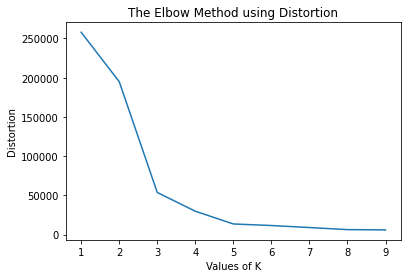

In [27]:
plt.plot(K, distortions) 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [28]:
kmeanModel = KMeans(n_clusters=5, random_state=23).fit(x2) 
kmeanModel.fit(x2) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=23, tol=0.0001, verbose=0)

In [0]:
clstr = {'T_Cluster':kmeanModel.labels_, 'Ticket':x2.reshape(705,)}

In [0]:
cluster1 = pd.DataFrame(clstr)

In [0]:
cluster1.T_Cluster = cluster1.T_Cluster.astype('category')

In [32]:
cluster1.groupby('T_Cluster').describe()

Ticket                              ...                                  
           count          mean           std  ...        50%         75%        max
T_Cluster                                     ...                                  
0          306.0  3.498652e+05  16782.052686  ...   349219.5   363293.25   394140.0
1           12.0  3.101280e+06     13.382485  ...  3101277.5  3101295.25  3101298.0
2          222.0  1.348882e+04  11708.642569  ...    11752.5    21306.00    54636.0
3           92.0  2.391790e+05   9323.351275  ...   239853.5   248700.00   250655.0
4           73.0  1.101857e+05  10937.388677  ...   113054.0   113783.00   113807.0

[5 rows x 8 columns]

In [0]:
x1 =data[-data['Ticket'].str.isnumeric()].Ticket.unique()
x = data[-data['Ticket'].str.isnumeric()].Ticket.str.replace(r'\W+','').unique()

In [0]:
lev_similarity = -1*np.array([[distance.levenshtein(x1,x2) for x1 in x] for x2 in x]) #dendo gramss wants a negetive matrix The symmetric non-negative hollow observation matrix looks suspiciously like

In [35]:
lev_similarity

array([[  0,  -7, -10, ...,  -9,  -5, -12],
       [ -7,   0, -12, ..., -10,  -7, -13],
       [-10, -12,   0, ..., -11, -11,  -3],
       ...,
       [ -9, -10, -11, ...,   0,  -8, -11],
       [ -5,  -7, -11, ...,  -8,   0, -12],
       [-12, -13,  -3, ..., -11, -12,   0]])

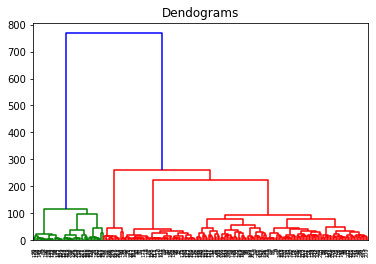

In [36]:
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(lev_similarity, method='ward'))

In [0]:
model = AgglomerativeClustering(distance_threshold=None, n_clusters=5)

In [0]:
model = model.fit(lev_similarity)

In [0]:
clstr = {'T_Cluster':model.labels_, 'Ticket':x1.reshape(224 ,)}

In [0]:
cluster2 = pd.DataFrame(clstr)

In [0]:
cluster2.T_Cluster = cluster2.T_Cluster + 4

In [0]:
cluster2.T_Cluster = cluster2.T_Cluster.astype('category')

In [43]:
cluster2.sort_values('Ticket')

,T_Cluster,Ticket
204,5,A. 2. 39186
9,5,A./5. 2152
134,5,A./5. 3235
180,5,A./5. 3338
41,5,A.5. 11206
...,...,...
23,5,W./C. 6608
65,5,W./C. 6609
25,5,W.E.P. 5734
59,5,W/C 14208


In [0]:
T_cluster = pd.concat([cluster1,cluster2], axis=0)

In [0]:
T_cluster.Ticket = T_cluster.Ticket.astype('str')

In [0]:
data  = data.merge(T_cluster, on= 'Ticket', how='left')

In [0]:
data.Pclass = data.Pclass.astype('category')
data.Sex = data.Sex.astype('category')
data.Cabin = data.Cabin.astype('category')
data.Embarked = data.Embarked.astype('category')
#data.Survived = data.Survived.astype('bool')
data.Istoddler = data.Istoddler.astype('bool')
data.IsChild = data.IsChild.astype('bool')
data.IsYoung = data.IsYoung.astype('bool')
data.T_Cluster = data.T_Cluster.astype('category')


In [0]:
data['Family_Size']= data.SibSp + data.Parch

In [52]:
'''
model  = DecisionTreeRegressor(random_state=0,criterion='mse')
X = pd.get_dummies(data[['Fare','Embarked','GroupSize','Age','Istoddler','IsChild','IsYoung','ToddlersPergroup','ChildrenPergroup','Youngpergroup','T_Cluster']].dropna(),drop_first=True)
y = X['Fare']
model = model.fit(X, y)
'''

"\nmodel  = DecisionTreeRegressor(random_state=0,criterion='mse')\nX = pd.get_dummies(data[['Fare','Embarked','GroupSize','Age','Istoddler','IsChild','IsYoung','ToddlersPergroup','ChildrenPergroup','Youngpergroup','T_Cluster']].dropna(),drop_first=True)\ny = X['Fare']\nmodel = model.fit(X, y)\n"

Using the standard way predicting Age

In [0]:
def get_model(activation, optimizer,batch_size):
  model = Sequential()
  model.add(Dense(32, input_shape = (i_shp,), activation = activation))
  model.add(BatchNormalization())
  model.add(Dense(32, activation=activation))
  model.add(BatchNormalization())
  model.add(Dense(1))
  model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mse'])
  return(model)


In [0]:
params = {'activation': ['relu', 'tanh'], 'batch_size': [32, 128, 256], 
          'epochs': [50, 100, 200], 'optimizer' : ['adam','sgd']}

In [0]:
model = KerasRegressor(build_fn=get_model, batch_size=16)

In [0]:
random_search = RandomizedSearchCV(model, param_distributions = params, cv = 3)

In [0]:
X_train = data[['Survived','Pclass','Fare','Age','Embarked','GroupSize','Istoddler','IsChild','IsYoung','ToddlersPergroup','ChildrenPergroup','Youngpergroup','T_Cluster','Family_Size']].dropna()

In [0]:
X = pd.get_dummies(X_train.drop('Age', axis=1), drop_first=True)
y = X_train['Age']
i_shp = len(X.columns.values)
X.Survived =  X.Survived.astype('int')
X.Istoddler =  X.Istoddler.astype('int')
X.IsChild =  X.IsChild.astype('int')
X.IsYoung =  X.IsYoung.astype('int')

In [59]:
random_search.fit(X,y)

NameError: ignored

In [0]:
random_search.best_params_

In [0]:
random_search.best_estimator_.predict(X).min()

You will see that we have negative values in ages which are not correct. so let's take the proposed approach.

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
y = min_max_scaler.fit_transform(np.float32(Y[:, np.newaxis]))

In [0]:
def get_model():
  model = Sequential()
  model.add(Dense(32, input_shape = (i_shp,), activation='tanh'))
  model.add(BatchNormalization())
  model.add(Dense(32, activation = 'tanh'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
  return(model)

In [0]:
model = get_model()

In [65]:
model.fit(X , y)

23/23 [==============================] - 0s 2ms/step - loss: 0.0724 - mse: 0.0706


In [0]:
y_pred = model.predict(X)

In [69]:
(min_max_scaler.inverse_transform(y_pred.T) - Y.values).min() # we have a model that predicts values with a presion of less than a year

-48.06328582763672

7720.609700279236

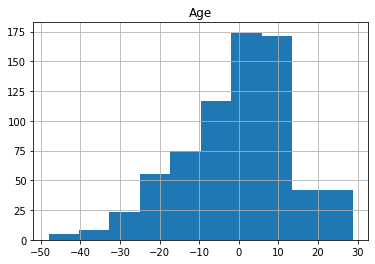

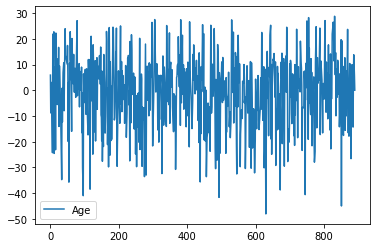

In [70]:
test = pd.DataFrame(min_max_scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(1,-1)[0]-Y)
test.hist()
test.plot()
abs(min_max_scaler.inverse_transform(y_pred.reshape(-1,1)).reshape(1,-1)[0]-Y).sum()